# Analyzing mean water level from UDM

## Experiment parameters

* Date: 2019-11-21
* Tank: SUSTAIN
* Start time: 16:10 UTC
* Wind only, no paddle
* Fan from 0 to 60 Hz in 5 Hz intervals, each run 600 s (10 minutes)
* Fresh water
* Mean water depth: 0.8 m

## Loading the data

In [1]:
from asist.utility import binavg, running_mean, power_spectrum
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import detrend
from sustain_drag_2020.udm import read_udm_from_toa5
from sustain_drag_2020.fetch import fetch
import warnings
warnings.filterwarnings('ignore')

In [2]:
# data parameters
DATAPATH = '/home/milan/Work/sustain/data/sustain-nsf-2019/20191121'
files = glob.glob(DATAPATH + '/TOA5_SUSTAIN_ELEVx6_20Hz*.dat')

# experiment parameters
fan = range(0, 65, 5)
run_seconds = 600
start_time = datetime(2019, 11, 21, 16, 10)
end_time = start_time + timedelta(seconds=run_seconds * len(fan))

In [3]:
# read UDM data from TOA5 files
time_, u1, u2, u3, u4, u5, u6 = read_udm_from_toa5(files)

Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1275_2019_11_21_1600.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1276_2019_11_21_1700.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1277_2019_11_21_1800.dat


## Remove offset, spikes, and flip sign

In [4]:
def elevation_from_udm(x):
    """Remove spikes and offset."""
    xx = x * np.ones(x.size)
    for n in range(10):
        for i in range(1, xx.size-1):
            if xx[i] > 1.5:
                xx[i] = 0.5 * (xx[i-1] + xx[i+1])
    offset = np.mean(xx[:(20 * 600)]) # offset first 10 minutes
    xx = offset - xx
    return xx

Text(0, 0.5, 'Elevation [m]')

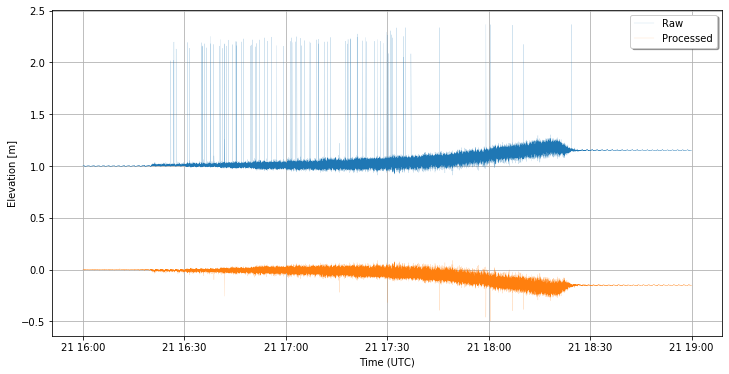

In [5]:
fig = plt.figure(figsize=(12, 6))
plt.plot(time_, u3, lw=0.1, label='Raw')
plt.plot(time_, elevation_from_udm(u3), lw=0.1, label='Processed')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.grid()
plt.xlabel('Time (UTC)')
plt.ylabel('Elevation [m]')

In [6]:
# trim time
exp_time = (time_ >= start_time) & (time_ <= end_time)
time = time_[exp_time]

x = fetch['udm']

# map UDM arrays to sequential positions in the tank
udm = np.zeros((x.size, time.size))
udm[0,:] = elevation_from_udm(u6[exp_time])
udm[1,:] = elevation_from_udm(u5[exp_time])
udm[2,:] = elevation_from_udm(u1[exp_time])
udm[3,:] = elevation_from_udm(u3[exp_time])
udm[4,:] = elevation_from_udm(u4[exp_time])

In [7]:
def remove_outliers(x, phigh=99, plow=1):
    xx = x * np.ones(x.size)
    high = np.percentile(xx, phigh)
    low = np.percentile(xx, plow)
    xx[xx > high] = high
    xx[xx < low] = low
    return xx

In [8]:
udm[0,:] = remove_outliers(udm[0,:], 100, 0.1)
udm[1,:] = remove_outliers(udm[1,:], 100, 0.15)
udm[2,:] = remove_outliers(udm[2,:], 100, 0.05)
udm[3,:] = remove_outliers(udm[3,:], 100, 0.05)
udm[4,:] = remove_outliers(udm[4,:], 100, 0.3)

## Computing mean elevation

In [9]:
# 9-minute time windows for each run; 
# we exclude the first minute (thus 9 and not 10) due to fan spinup
t0 = [start_time + timedelta(seconds=n * run_seconds + 60)
    for n in range(len(fan))]
t1 = [start_time + timedelta(seconds=(n + 1) * run_seconds)
    for n in range(len(fan))]

In [10]:
h = np.zeros((len(fan), x.size))
for n in range(len(fan)):
    mask = (time >= t0[n]) & (time <= t1[n])
    for i in range(x.size):
        h[n,i] = np.mean(udm[i,mask])

## Mean elevation as function of fan speed, for each UDM

Text(0.5, 1.0, 'Mean elevation as function of fan speed')

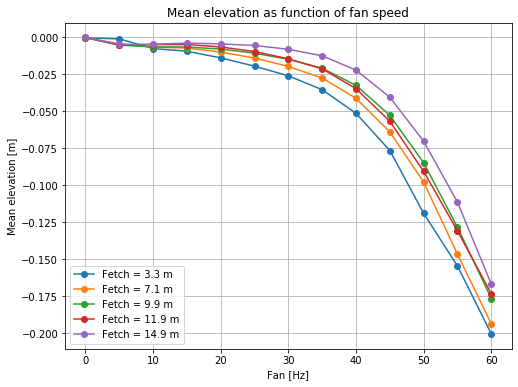

In [11]:
fig = plt.figure(figsize=(8, 6))
for i in range(x.size):
    plt.plot(fan, h[:,i], marker='o', label='Fetch = %.1f m' % x[i])
plt.legend()
plt.grid()
plt.xlabel('Fan [Hz]')
plt.ylabel('Mean elevation [m]')
plt.title('Mean elevation as function of fan speed')

## Mean elevation as function of fetch, for each fan speed

Text(0.5, 1.0, 'Mean elevation as function of fan speed')

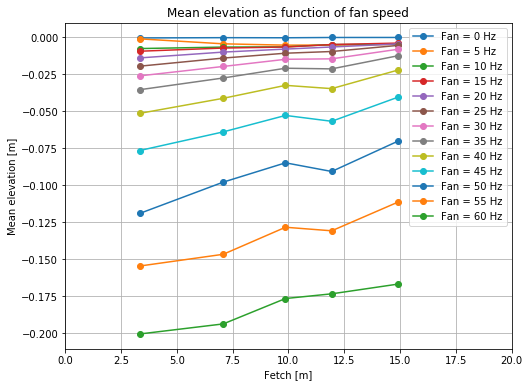

In [12]:
fig = plt.figure(figsize=(8, 6))
for n in range(len(fan)):
    plt.plot(x, h[n,:], marker='o', label='Fan = %i Hz' % fan[n])
plt.legend()
plt.grid()
plt.xlim(0, 20)
plt.xlabel('Fetch [m]')
plt.ylabel('Mean elevation [m]')
plt.title('Mean elevation as function of fan speed')

## Fit a line to find the mean slope

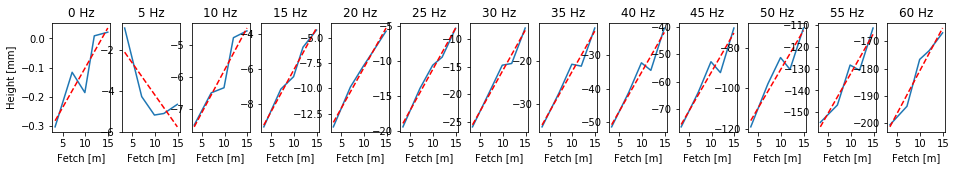

In [13]:
fig = plt.figure(figsize=(16, 2))
dhdx = np.zeros(len(fan))
for n in range(len(fan)):
    ax = plt.subplot2grid((1, len(fan)), (0, n))
    plt.plot(x, 1e3 * h[n,:]) # to millimeters
    p = np.polyfit(x, 1e3 * h[n,:], 1)
    fit = np.polyval(p, x)
    plt.plot(x, fit, 'r--')
    plt.xlabel('Fetch [m]')
    if n == 0: plt.ylabel('Height [mm]')
    plt.title(str(fan[n]) + ' Hz')
    dhdx[n] = 1e-3 * (fit[-1] - fit[0]) / (x[-1] - x[0]) # back to meters

In [14]:
dhdx

array([ 2.75598832e-05, -3.15914114e-04,  2.64593950e-04,  4.77135094e-04,
        8.06226998e-04,  1.17430784e-03,  1.48549252e-03,  1.88376572e-03,
        2.36234711e-03,  2.88447347e-03,  3.84842351e-03,  3.66076268e-03,
        3.13321269e-03])

Text(0.5, 1.0, 'Mean slope as function of fan speed')

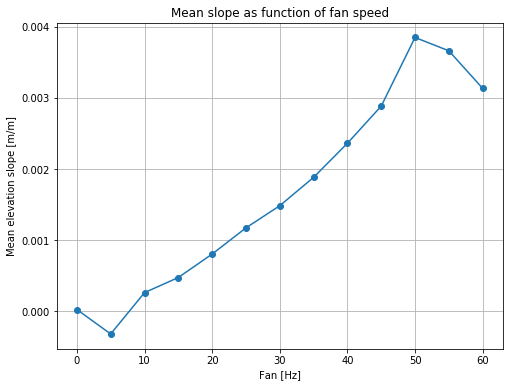

In [15]:
fig = plt.figure(figsize=(8, 6))
plt.plot(fan, dhdx, marker='o')
plt.grid()
plt.xlabel('Fan [Hz]')
plt.ylabel('Mean elevation slope [m/m]')
plt.title('Mean slope as function of fan speed')